<a href="https://colab.research.google.com/github/aleks-haksly/Simulative/blob/main/ML/recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://a.teleboss.ru/play/c851b57a-ccd5-408c-9484-e3d00c79b46e

https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system/data?select=movies.csv

# Загрузка датасета с kaggle

In [1]:
!curl -L -o movie-recommendation-system.zip https://www.kaggle.com/api/v1/datasets/download/parasharmanas/movie-recommendation-system
!unzip -o /content/movie-recommendation-system.zip
!rm *.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  164M  100  164M    0     0  76.2M      0  0:00:02  0:00:02 --:--:--  108M
Archive:  /content/movie-recommendation-system.zip
  inflating: movies.csv              
  inflating: ratings.csv             


In [2]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 54.5 MB/s eta 0:00:00


In [91]:
import numpy as np
import pandas as pd
import os
import pickle
import warnings
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import RandomizedSearchCV

#warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

In [4]:
ratings_full_df = pd.read_csv("/content/ratings.csv", nrows=200_000)
movies_df = pd.read_csv("/content/movies.csv")

In [5]:
ratings_full_df.head(3)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [6]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [7]:
X_ = ratings_full_df.drop("rating", axis=1)
y_ = ratings_full_df['rating']

# Подготовка pipline для обработки
## Часть 1 - Пишем cамый примитивный baseline Estimator

Он будет использоваться как baseline для дальнейших экспериментов

In [8]:
class NaivePredictor(ClassifierMixin, BaseEstimator):

    def __init__(self, a=0.5, avg=np.median):
        self.rating_movie_mean_ = None  # Для хранения средней оценки фильма
        self.rating_user_mean_ = None  # Для хранения средней оценки которую ставит пользователь
        self.a = a  # Параметр, который будем менять при подборе по сетке GridSearchCV для определения долей влияния средней оценки фильма и среднй оценки пользователя
        self.avg = avg # Параметр, который будем менять при подборе по сетке GridSearchCV для выбора способа оценки среднего выборки
        self.classes_ = [0] # Технический момент, никак не используется, но атрибут должен существовать для корректной работы GridSearchCV

    def fit(self, X, y):
        concatenated_df = pd.concat([X, y], axis=1)
        self.rating_movie_mean_ = concatenated_df.groupby('movieId')['rating'].apply(self.avg) # Средняя оценка фильма
        self.rating_user_mean_ = concatenated_df.groupby('userId')['rating'].apply(self.avg) # Средняя оценка, которую ставит пользователь
        self.global_avg = y.pipe(self.avg) # Средняя всех оценок в тренировочном датасете

        return self

    def predict(self, X):
        """
        Предсказывает средний рейтинг фильма как сумму долей средней оценки фильма и среднй оценки, которую обычно ставит пользователь
        Если `movieId` нет в обучающей выборке, возвращает средний рейтинг по всем фильмам.
        """
        if self.rating_movie_mean_ is None:
            raise ValueError("Model is not fitted yet. Call `fit` before `predict`.")

        predictions = (X['movieId'].map(self.rating_movie_mean_) * self.a +
                       X['userId'].map(self.rating_user_mean_) * (1 - self.a))\
                       .fillna(self.global_avg) # Заполняем пропущенные значения средним рейтингом всех фильмов

        return predictions

In [9]:
# Базовый пайплайн, без трансформеров датасета
pipe = Pipeline(
    [
        ("NaivePredictor", NaivePredictor())
    ]
)

In [10]:
# Для кросс валидации будем использовать KFold
splitter = KFold(
    n_splits=5, # Разбиваем на 5 частей и поочередно используем каждую часть как test
    shuffle=True,
    random_state=42
)

In [11]:
# Для подбора по сетке будем пробовать разные коэффициенты a и разные оценки среднего
param_grid = {
    "NaivePredictor__a": np.arange(start=0.1, stop=1.1, step=0.1),
    "NaivePredictor__avg": [np.mean, np.median]
}

In [12]:
# Перебираем все комбинации из переметров из param_grid
%%time
search_naive = GridSearchCV(pipe,
                      param_grid,
                      cv=splitter,
                      scoring='neg_mean_absolute_error', # В качестве метрики для выбора лучшей модели возьмем MAE
                      verbose=1,
                      return_train_score=True,
                      error_score="raise")

search_naive.fit(X_, y_)
print(f"Best parameter (CV score={search_naive.best_score_:.5f}):")
print(search_naive.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameter (CV score=-0.69944):
{'NaivePredictor__a': 0.4, 'NaivePredictor__avg': <function median at 0x7e75c5165f30>}
CPU times: user 1min 47s, sys: 2.24 s, total: 1min 49s
Wall time: 2min 7s


Best parameter (CV score=-0.69944):
{'NaivePredictor__a': 0.4, 'NaivePredictor__avg': <function median at 0x7bffe353caf0>}

In [13]:
# Функция для более комплексной оценки полученной модели, вычисляет большее количество метрик качества
def evaluate_model(y_true, y_predicted):
  '''
  Функция для расчета прочих оценочных метрик модели
  '''
  result = pd.DataFrame.from_dict({
          "MAE": f'{mean_absolute_error(y_true, y_predicted):.3f}',
          "MSE": f'{mean_squared_error(y_true, y_predicted):.3f}',
          "MAPE": f'{mean_absolute_percentage_error(y_true, y_predicted):.2%}',
          "R2_score": f'{r2_score(y_true, y_predicted):.3f}'
  },
  orient='index', columns=['value'])
  return result

In [14]:
# Воспользуемся базовым train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_,
    y_,
    test_size=0.2, # Доля теста к тотал данным
    random_state=42  # Мешать ли данные или делить по индексам
)

In [15]:
# Посмотрим оценки навной модели модели (они довольно хорошие)
evaluate_model(y_test, search_naive.predict(X_test))

,value
MAE,0.666
MSE,0.792
MAPE,30.93%
R2_score,0.273


# Часть 2 Предобработка данных и применение LinearRegression

In [47]:
# Заранее зафитим MultiLabelBinarizer, который будет преобразовывать колонку с жанрами в отельные столбцы
mlb_genres = MultiLabelBinarizer()
mlb_genres.fit(movies_df.genres.apply(lambda x: x.split('|')))

MultiLabelBinarizer()

In [76]:
# Напишем свой класс для предварительной трансформации данных
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        movies_data=movies_df, # база данных всех фильмов
        avg=np.mean, # для дальнейшей проверки в GridSearchCV, что будет лучше работать mran или median

    ):

        self.mlb = mlb_genres
        self.movies_data = movies_data
        self.avg = avg

    def fit(self, X, y):


        X_train_copy = X.copy()
        X_train_copy = pd.concat([X_train_copy, y], axis = 1)
        X_train_copy = X_train_copy.merge(movies_df[['movieId', 'genres']], on='movieId', how='left')

        #  Для каждого user в train рассчитаем среднюю оценку, которую он ставит фильмам
        self.rating_user_mean = X_train_copy.groupby("userId")\
                                               .rating.apply(self.avg)\
                                               .rename("rating_user_mean")

        #  Для каждого movie в train рассчитаем среднюю оценку, которую он получает от пользователь
        self.rating_movie_mean = X_train_copy.groupby("movieId")\
                                                .rating.apply(self.avg)\
                                                .rename("rating_movie_mean")

        # Для каждого пользователя рассчитаем среднюю оценку, которую он ставит в каждом жанре фильма, для чего сначала выдлим все жанры и проставим им оценки для каждой записи train
        self.mlb_encoded_genres = pd.concat([
            X_train_copy.userId,
            pd.DataFrame(self.mlb.transform(X_train_copy.genres.apply(lambda x: x.split('|'))), \
                                          columns=self.mlb.classes_, index = X_train_copy.index).mul(X_train_copy.rating, axis=0)
        ], axis=1)
        # А затем сгуппируем по пользователям и усредним
        self.mean_genres_by_users = self.mlb_encoded_genres.groupby("userId").mean()#.rename("mean_genres_by_users")
        self.mean_rating = y.pipe(self.avg) # средний рейтинг всех фильмов train для заполнения пропусков в дальнейшем при трансформации X_test
        return self

    def transform(self, X:pd.DataFrame):

        X_copy= X.copy()
        # Добавим к X_test иформацию их X_train о средних для фильма и средних для пользователя рейтингах. Пропуски заполним средним рейтингом всех фильмов.
        X_copy = X_copy.merge(self.movies_data[['movieId', 'genres']], on='movieId', how='left')\
                       .merge(self.rating_user_mean, left_on='userId', right_index=True, how='left')\
                       .merge(self.rating_movie_mean, left_on='movieId', right_index=True, how='left').fillna(self.mean_rating)

        datetime_ = pd.to_datetime(X_copy.timestamp, unit='s')
        """
        # Эти признаки в дальнейшем показали свою бесполезность
        X_copy['year'] = datetime_.dt.year
        X_copy['day'] = datetime_.dt.day
        X_copy['hour'] = datetime_.dt.hour
        X_copy['month'] = datetime_.dt.month
        """

        X_copy['day_of_week'] = datetime_.dt.day_of_week

        # Создадим признак того, в какое время дня был посмотрен фильм. В дальнейшем применим на эту колонку OneHotEncoder
        X_copy['time'] = pd.cut(datetime_.dt.hour,
                                include_lowest=True,
                                bins=[0, 5, 12, 17, 21, 24],
                                right=False,
                                ordered=False,
                                labels=['night', 'morining', 'afternoon', 'evening', 'night'])


        # добавим к X_train колонки, кодирующие признак, к какому жанру принадлежит текущий фильм
        X_copy = pd.concat([X_copy, pd.DataFrame(self.mlb.transform( X_copy.genres.apply(lambda x: x.split('|'))),\
                                         columns=self.mlb.classes_)], axis=1)
        # добавим к X_train колонки с информацией о том, какие в среднем оценки получает каждый жанр от текущего пользователя
        X_copy = X_copy.merge(self.mean_genres_by_users, how='left', left_on='userId', right_index=True, suffixes=("", "_mean"))
        # дропнем кололнки, которые мы используем трансформированными и те, что нам точно не пригодятся для предсказания рейтинга фильма
        X_copy.drop(columns=['timestamp', 'genres', 'userId',  'movieId',], inplace=True)
        return X_copy.set_index(X.index) # для надежности вернем первоначальный индекс, в X_test


In [49]:
onehot_columns = ['time'] # список колонок, которые будем кодировать c OneHotEncoder

In [50]:
col_transformer = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), onehot_columns),
    ],
    remainder='passthrough',          # Оставляем необрабатываемые колонки как есть, не удаляем их
    verbose_feature_names_out=False   # Оставляем оригинальные названия колонок
).set_output(transform='pandas')      # Трансформер будет возвращать pandas


## 2.1 Предварительное исследование получившегося датасета, на котором будем обучать модели

In [78]:
# Промежуточный pipeline для получения трансформированного X_test
research_pipe = Pipeline(
    [
        ("Custom_transformer", CustomTransformer()),
        ("OneHotEncoder", col_transformer)
    ]
)

In [79]:
# Посмотрим на попарную корреляцию признаков
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Топ 10 самых сильных корреляций в данных")
print(get_top_abs_correlations(df, 10))
# корреляций выше 0.85 нет, удалять колонки на этот раз не будем)

Топ 10 самых сильных корреляций в данных
rating_user_mean  mean_genres_by_users    0.801850
Animation         Children                0.652301
time_evening      time_night              0.412645
time_morining     time_night              0.363899
Action            Adventure               0.334157
                  Sci-Fi                  0.322624
Comedy            Thriller                0.322219
Children          Musical                 0.311809
Animation         Musical                 0.310463
Children          Fantasy                 0.308704
dtype: float64


In [23]:
# Иссдуем корреляцию также методом Variance Inflation Factor
vif_df = pd.DataFrame()
vif_df['feature'] = df.columns
vif_df['VIF'] = [vif(df.values, i) for i in range(len(df.columns))]
vif_df.query("VIF >= 10")

,feature,VIF
3,rating_user_mean,136.420670
4,rating_movie_mean,39.907734
26,mean_genres_by_users,90.423098


Некоторые признаки, такие как rating_user_mean, mean_genres_by_users, rating_movie_mean имеют достаточно высоку корреляцию, что логично, так как методы их получения в чем-то схожи, особенно для первых двух. Однако их удаление из датасета ведет к ухудшению показателей точности модели, поэтому пока трогать их не будем

In [80]:
# В качестве линейной регрессии попробуем Ridge и Lasso регрессию
lasso_pipe = Pipeline(
    [
        ("Custom_transformer", CustomTransformer()),
        ("OneHotEncoder", col_transformer),
        ("simple_model", Lasso())
    ]
)

ridge_pipe = Pipeline(
    [
        ("Custom_transformer", CustomTransformer()),
        ("OneHotEncoder", col_transformer),
        ("simple_model", Ridge())
    ]
)

In [81]:
# Сетка для подбора оптимальных параметров
param_grid = {
    "simple_model__alpha": np.logspace(-1, 3, 10),
    "simple_model__max_iter": [100, 1000],
    "Custom_transformer__avg": [np.mean, np.median],
}

In [82]:
%%time
for model in [lasso_pipe, ridge_pipe]:

    search = GridSearchCV(model,
                          param_grid,
                          cv=splitter,
                          scoring='neg_mean_absolute_error', # В качестве метрики для выбора лучшей модели возьмем MAE
                          verbose=1,
                          return_train_score=True,
                          error_score="raise")

    search.fit(X_, y_)

    print(f"Best parameter (CV score={search.best_score_:.5f}):")
    print(search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameter (CV score=-0.71232):
{'Custom_transformer__avg': <function mean at 0x7e75c7d1f9f0>, 'simple_model__alpha': 0.1, 'simple_model__max_iter': 100}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameter (CV score=-0.67854):
{'Custom_transformer__avg': <function mean at 0x7e75c7d1f9f0>, 'simple_model__alpha': 359.38136638046257, 'simple_model__max_iter': 100}
CPU times: user 25min 10s, sys: 1min 57s, total: 27min 7s
Wall time: 25min 39s


In [83]:
# Коэффициенты лучшей модели
search.best_estimator_.named_steps.simple_model.coef_

array([ 4.57380493e-03, -2.52366002e-03,  2.58145668e-02,  8.91751844e-01,
        8.91648365e-01,  3.39743767e-03,  2.60744569e-02, -2.68923099e-02,
       -6.06214773e-03,  3.13276734e-02, -6.72533540e-02, -2.47203881e-02,
        2.07600043e-02,  9.80125861e-02,  2.92697110e-02,  1.64027407e-03,
        2.28746293e-02, -3.52700905e-03, -4.67034811e-02, -1.84905606e-03,
        1.21699793e-02, -1.70169548e-02, -2.18534846e-02, -1.42800817e-02,
        1.17507419e-02,  2.52456740e-02,  1.41783949e-02,  1.33100166e-01,
       -1.52616299e-01, -1.25833699e-01,  2.35422169e-01,  5.40370405e-02,
       -2.09685597e-01, -7.27740524e-02, -6.96139681e-02, -1.19955013e-02,
       -6.57195280e-02,  6.73073233e-02, -2.21700564e-02, -6.23506143e-02,
       -1.76921657e-01, -8.94391456e-05, -6.67119922e-02,  1.45065377e-01,
       -1.36389520e-01, -2.09307904e-02])

In [85]:
# Проверим, что модель покажет на общем тесте
evaluate_model(y_test, search.predict(X_test))

,value
MAE,0.631
MSE,0.677
MAPE,26.85%
R2_score,0.378


Полученная модель несколько лучше показывает себя, в сравнении с первоначальной самописаной навной модлью.

## Чкасть 3 решающие деревья, XGBRegressor

In [86]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()

In [87]:
XGBR_pipe = Pipeline(
    [
        ("Custom_transf", CustomTransformer()),
        ("OneHotEncoder", col_transformer),
        ("XGBR_model", XGBRegressor())
    ]
)

In [89]:
param_grid = {
    'XGBR_model__max_depth': [7, 9],         # Different depths for the trees
    'XGBR_model__gamma': [0.1, 0.15, 0.3],         # Minimum loss reduction to make a split
    'XGBR_model__alpha': [0.1, 0.15, 0.3],         # L1 regularization term on weights
    'XGBR_model__reg_lambda': [1.5, 2, 2.5],          # L2 regularization term on weights
    'XGBR_model__learning_rate': [0.02, 0.05, 0.1], # Learning rate
    'XGBR_model__n_estimators': [200, 300]   # Number of trees
}

In [90]:
random_search = RandomizedSearchCV(
    estimator=XGBR_pipe,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    error_score="raise",
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [92]:
with open('XGBR_model.pkl','wb') as f:
    pickle.dump(best_model,f)

In [33]:
print("Best Parameters:", best_params)

Best Parameters: {'XGBR_model__reg_lambda': 1.5, 'XGBR_model__n_estimators': 200, 'XGBR_model__max_depth': 9, 'XGBR_model__learning_rate': 0.05, 'XGBR_model__gamma': 0.1, 'XGBR_model__alpha': 0.15}


Best Parameters: {'XGBR_model__reg_lambda': 1.5, 'XGBR_model__n_estimators': 200, 'XGBR_model__max_depth': 9, 'XGBR_model__learning_rate': 0.1, 'XGBR_model__gamma': 0.3, 'XGBR_model__alpha': 0.15}

In [94]:
predict = best_model.predict(X_test)
evaluate_model(y_test, predict)

,value
MAE,0.650
MSE,0.724
MAPE,27.25%
R2_score,0.335


## 4 Посмотрим на важность признаков, которыую выделил XGBR

<BarContainer object of 46 artists>

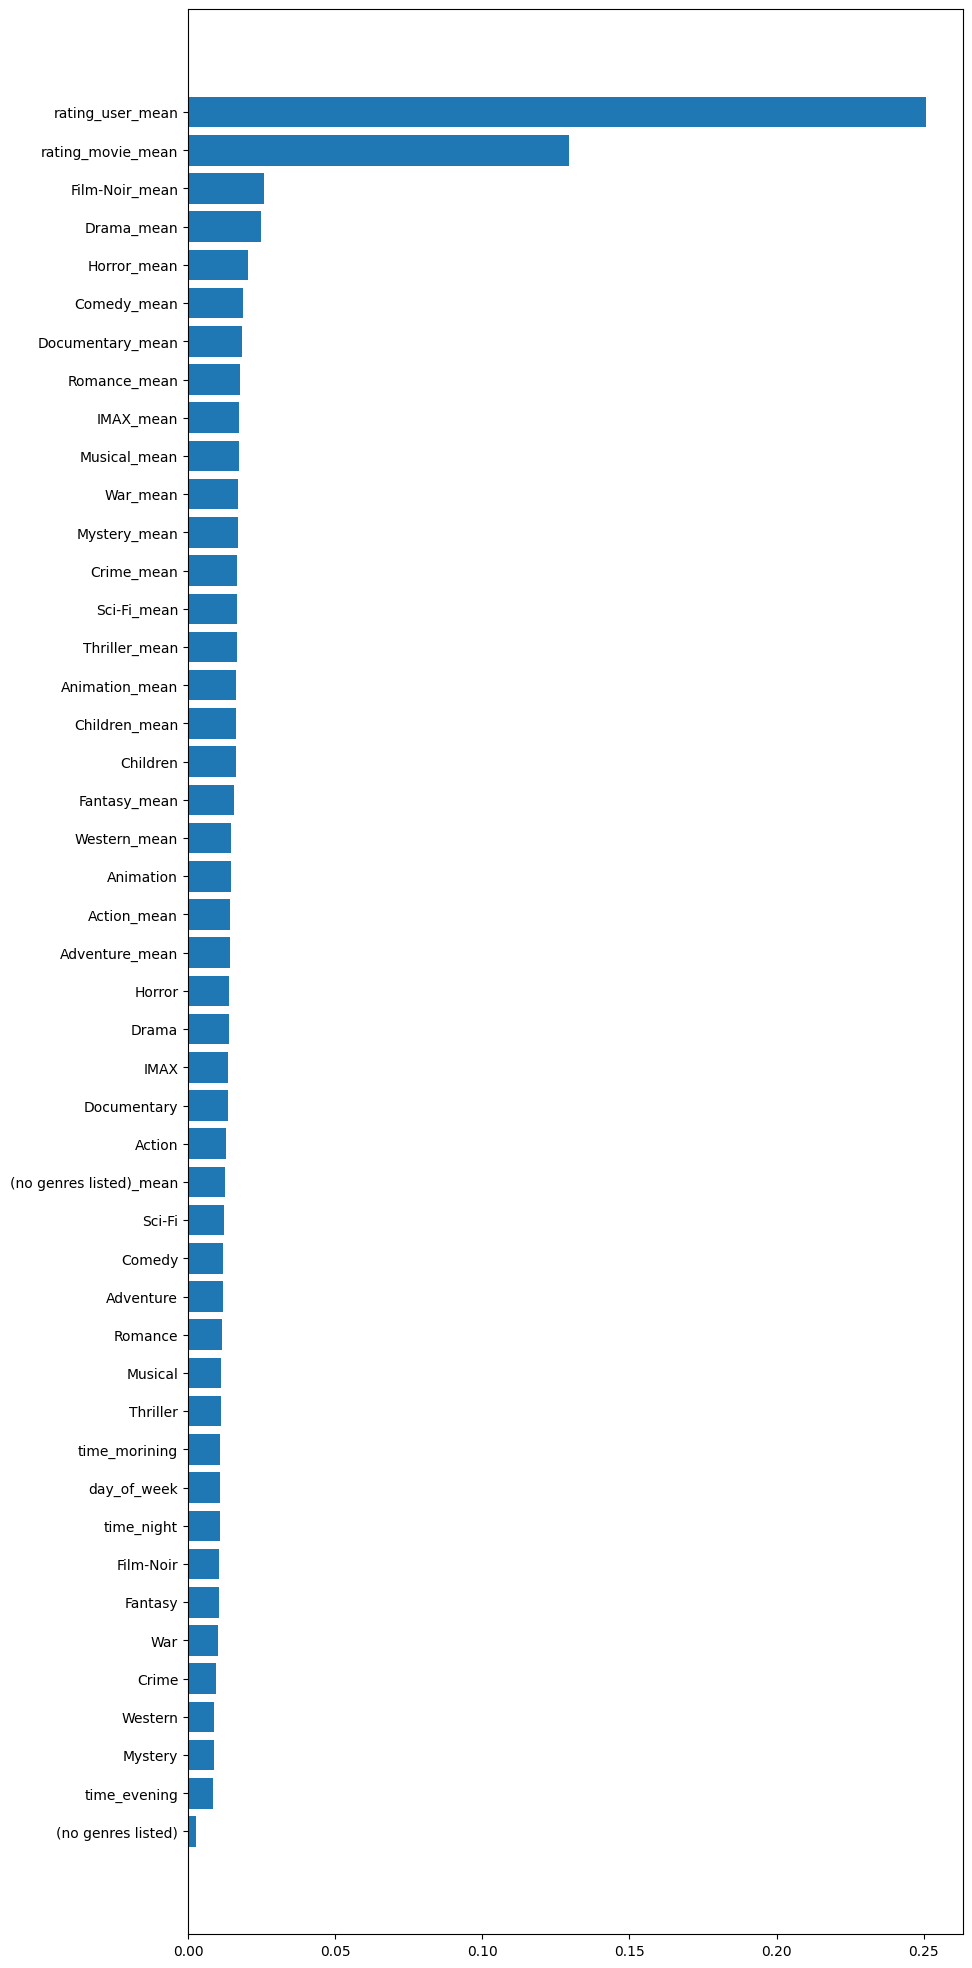

In [96]:
import matplotlib.pyplot as plt

df = research_pipe.fit(X_, y_).transform(X_test)
sorted_idx = best_model._final_estimator.feature_importances_.argsort()
plt.figure(figsize=(10,25))
plt.barh(df.columns[sorted_idx], best_model._final_estimator.feature_importances_[sorted_idx])